In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('archive/daily/AALI.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [4]:
data.isna().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [5]:
# split data menjadi test dan train

train_size = int(len(data) * 0.8)
data_train, data_test = data[:train_size], data[train_size:]

In [6]:
# Normalisasi setelah di split

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.transform(data_test)

In [7]:
# Membuat sequence untuk LSTM input

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])
    return np.array(sequences), np.array(targets)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

In [8]:
# split train menjadi train dan validation set

train_val_split = int(len(X_train) * 0.8)
X_train_final, X_val = X_train[:train_val_split], X_train[train_val_split:]
y_train_final, y_val = y_train[:train_val_split], y_train[train_val_split:]

In [9]:
# Definisikan Model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, data.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

f:\KULIAH\SEM 4\MachineLearning\FinalProject\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train model

history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0293 - val_loss: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0028 - val_loss: 8.2404e-04
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0022 - val_loss: 8.5546e-04
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0022 - val_loss: 6.4394e-04
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0020 - val_loss: 5.3818e-04
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0019 - val_loss: 5.8792e-04
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0021 - val_loss: 9.7548e-04


In [11]:
# Predict model evaluasi

train_predictions = model.predict(X_train_final)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [12]:
# rescale prediksi dan true value untuk perbandingan

test_predictions_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((test_predictions.shape[0], 3)), test_predictions, np.zeros((test_predictions.shape[0], 1))), axis=1)
)[:, 3]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1)
)[:, 3]

In [13]:
# hitung metrics untuk data yang sudah dinormalisasi dan yang belum

mse_train = mean_squared_error(y_train_final, train_predictions)
mape_train = mean_absolute_percentage_error(y_train_final, train_predictions)
r2_train = r2_score(y_train_final, train_predictions)

mse_val = mean_squared_error(y_val, val_predictions)
mape_val = mean_absolute_percentage_error(y_val, val_predictions)
r2_val = r2_score(y_val, val_predictions)

mse_test = mean_squared_error(y_test, test_predictions)
mape_test = mean_absolute_percentage_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)

print(f'MSE (Train, Normalized): {mse_train}, MAPE (Train, Normalized): {mape_train}, R² (Train, Normalized): {r2_train}')
print(f'MSE (Validation, Normalized): {mse_val}, MAPE (Validation, Normalized): {mape_val}, R² (Validation, Normalized): {r2_val}')
print(f'MSE (Test, Normalized): {mse_test}, MAPE (Test, Normalized): {mape_test}, R² (Test, Normalized): {r2_test}')

MSE (Train, Normalized): 0.0007439596105698057, MAPE (Train, Normalized): 0.06932596962476421, R² (Train, Normalized): 0.9906766854597896
MSE (Validation, Normalized): 0.0009754782552154331, MAPE (Validation, Normalized): 0.054467929323844956, R² (Validation, Normalized): 0.8791167331131532
MSE (Test, Normalized): 0.0005070682165543495, MAPE (Test, Normalized): 0.06448192088096441, R² (Test, Normalized): 0.8482129376552889


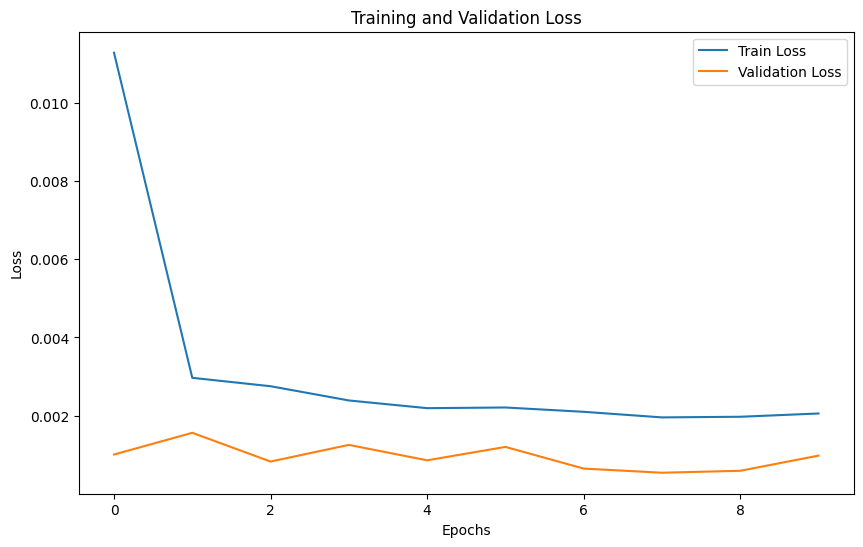

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

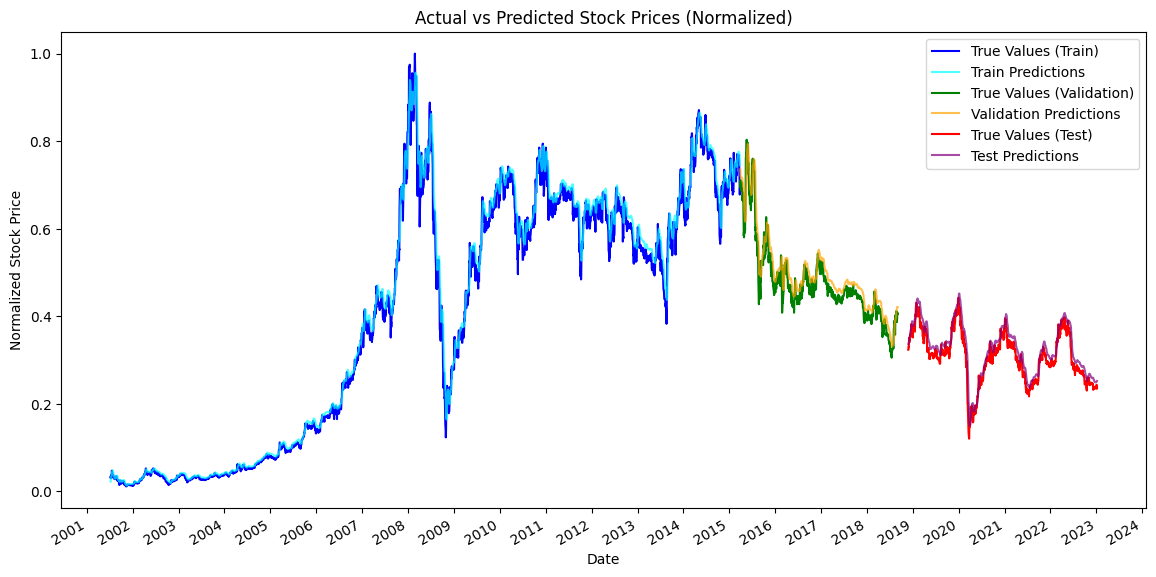

In [15]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

train_dates = data.index[seq_length:train_val_split + seq_length]
val_dates = data.index[train_val_split + seq_length:train_val_split + seq_length + len(val_predictions)]
test_dates = data.index[train_size + seq_length:train_size + seq_length + len(test_predictions)]

plt.plot(train_dates, y_train_final, label='True Values (Train)', color='blue')
plt.plot(train_dates, train_predictions, label='Train Predictions', color='cyan', alpha=0.7)

plt.plot(val_dates, y_val, label='True Values (Validation)', color='green')
plt.plot(val_dates, val_predictions, label='Validation Predictions', color='orange', alpha=0.7)

plt.plot(test_dates, y_test, label='True Values (Test)', color='red')
plt.plot(test_dates, test_predictions, label='Test Predictions', color='purple', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.show()